In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from scipy.stats import skew, kurtosis
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import find_peaks, savgol_filter 
from scipy.ndimage import uniform_filter1d


from astropy.stats import median_absolute_deviation as MAD


In [2]:
from matplotlib import rc
# from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.font_manager
import matplotlib.colors as colors


plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 18


SMALL_SIZE = 15
MEDIUM_SIZE = 17
BIGGER_SIZE = 19

plt.rc('font', size=SMALL_SIZE)          # controls default text
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)


In [3]:
# read the file
df = pd.read_csv("Data/Additional_EIRPs/Kiricom_Radio_On_MAX_100kHz_EIRP.csv")
df.columns.tolist()

['Frequency(MHz)', 'EIRP(dBm)', 'BG_EIRP(dBm)']

In [36]:
#define the variables
freq = df["Frequency(MHz)"]
signal_dBm = df[' EIRP(dBm)']
background_dBm = df[" BG_EIRP(dBm)"]


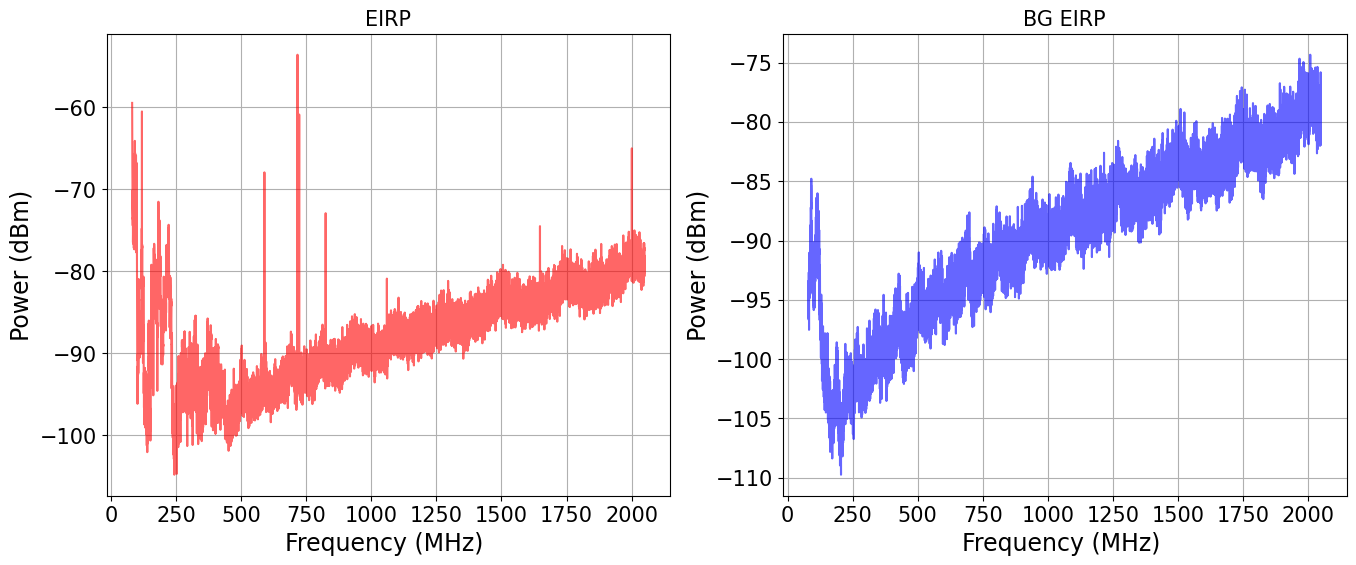

In [37]:
# plot the frequency in function of the amplitude (on-source and off-source)


fig, axs = plt.subplots(1,2, figsize=(16,6))
#fig.subplots_adjust(wspace=0.2)

# frequ domain plots

axs[0].plot(freq, signal_dBm, color='red', alpha=0.6)
axs[0].set_xlabel('Frequency (MHz) ')
axs[0].set_ylabel('Power (dBm)')
axs[0].set_title('EIRP')
axs[0].grid(True)


axs[1].plot(freq, background_dBm, color='blue', alpha=0.6)
axs[1].set_title('BG EIRP')
axs[1].set_xlabel('Frequency (MHz) ')
axs[1].set_ylabel('Power (dBm)')
axs[1].grid(True)


#plt.savefig('Plots/INCA_Camera+BG.png')



<Axes: >

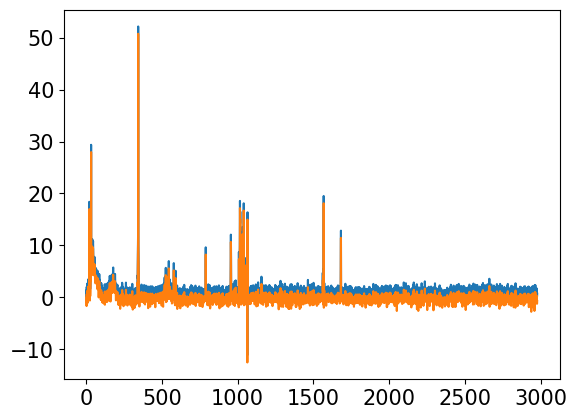

In [15]:
si = df[' EIRP(dBm)'] - df[' BG_EIRP(dBm) ']
det = si - np.mean(si)

si.plot()
det.plot()

# Remove the back groud signal 

To remove the back-group noite:
1. convert the measurements form (dBm) to mW, i.e, from log-scale for liner scale.
2. perfome the substraction of the back-groud 
3. convert back to log scale

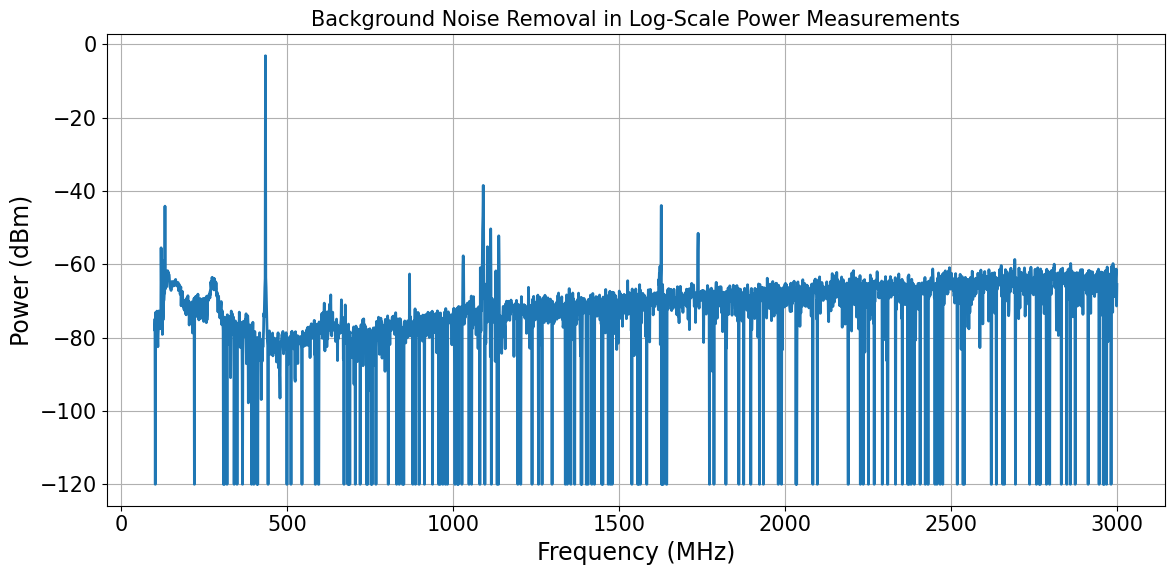

In [16]:

# Convert dBm to mW
signal_mW = 10 ** (signal_dBm / 10)
background_mW = 10 ** (background_dBm / 10)

# Subtract background in linear scale
clean_mW_test = np.maximum(signal_mW - background_mW, 1e-12)

# Convert back to dBm
clean_dBm_test = 10 * np.log10(clean_mW_test)


# # Convert back to dBm, handling cases where result was 0 mW
# cleaned_dbm = 10 * np.log10(cleaned_mW, where=(cleaned_mW > 0))
# cleaned_dbm[cleaned_mW == 0] = -np.inf  # or some very low dBm value
    

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(freq, clean_dBm_test, linewidth=2)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power (dBm)")
plt.title("Background Noise Removal in Log-Scale Power Measurements")
plt.grid(True)
plt.tight_layout()
plt.show()


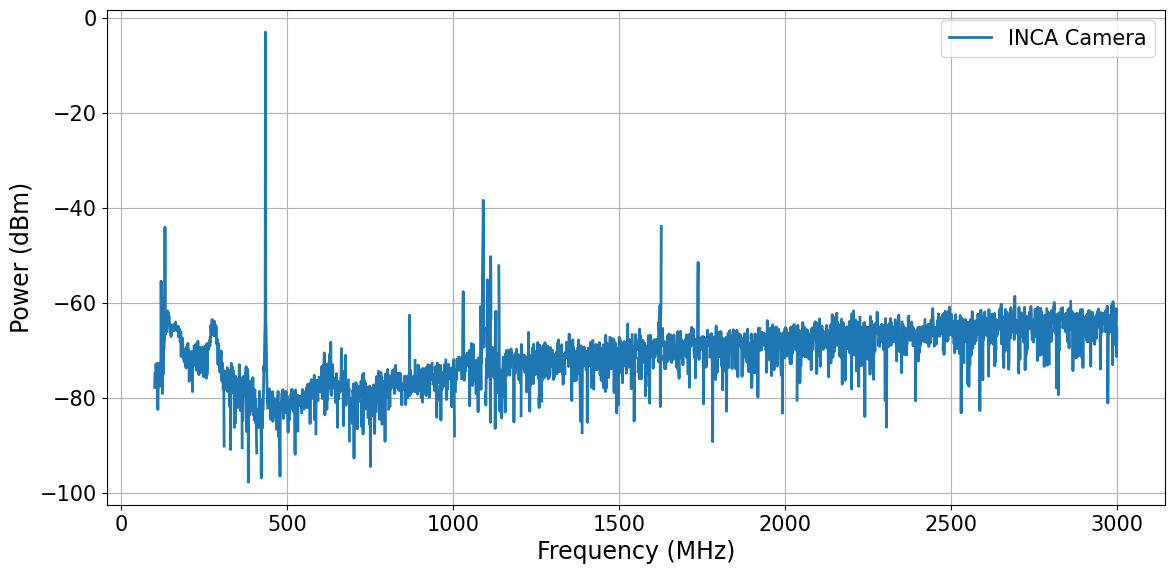

In [17]:

# Convert dBm to mW
signal_mW = 10 ** (signal_dBm / 10)
background_mW = 10 ** (background_dBm / 10)

# Subtract background in linear scale
cleaned_mW = signal_mW - background_mW

cleaned_mW[cleaned_mW <= 0] = np.nan


# Convert back to dBm
cleaned_dBm = 10 * np.log10(cleaned_mW)


# # Convert back to dBm, handling cases where result was 0 mW
# cleaned_dbm = 10 * np.log10(cleaned_mW, where=(cleaned_mW > 0))
# cleaned_dbm[cleaned_mW == 0] = -np.inf  # or some very low dBm value
    

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(freq, cleaned_dBm, label="INCA Camera", linewidth=2)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power (dBm)")
#plt.title("Background Noise Removal in Log-Scale Power Measurements")
plt.legend()
plt.grid(True)
plt.tight_layout()


#plt.savefig('Plots/INCA_Camera_BG-removed.png')


In [18]:
cleaned_dBm

0      -77.838629
1      -74.872236
2             NaN
3      -73.117842
4      -77.358069
          ...    
2974   -63.972201
2975   -62.580087
2976   -61.273171
2977   -71.345511
2978   -65.479681
Length: 2979, dtype: float64

# ---> Let creat new data frame to avoid the missing data

In [19]:
data = {'Frequency (MHz)': freq, 'Clean_dBm': cleaned_dBm}
df1 = pd.DataFrame(data, )
df1 = df1.dropna()
df1

,Frequency (MHz),Clean_dBm
0,100.440000,-77.838629
1,101.413333,-74.872236
3,103.360000,-73.117842
4,104.333333,-77.358069
5,105.306667,-75.623615
...,...,...
2974,2995.133333,-63.972201
2975,2996.106667,-62.580087
2976,2997.080000,-61.273171
2977,2998.053333,-71.345511


len(freq2.values)=2821


<Axes: >

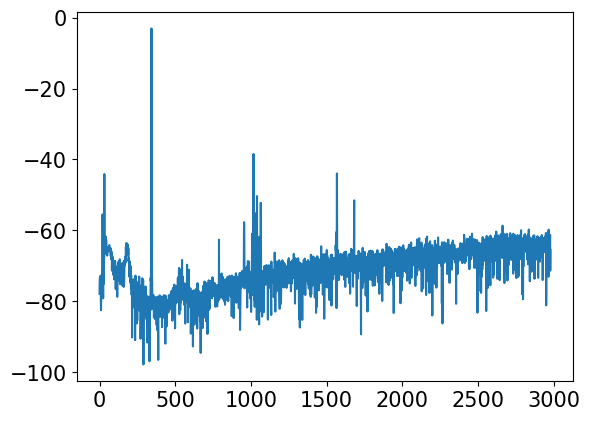

In [20]:
freq2 = df1['Frequency (MHz)']
clean_sig2 = df1['Clean_dBm']
print(f"{len(freq2.values)=}")
clean_sig2.plot()

# Detrend Signal 

For detrendig we will use Polynomial fitting and Savistky-Golay

--> To determine the best polynomial order for fitting data (e.g., for detrending), use the Bayesian Information Criterion (BIC) — a standard method for model selection that balances fit quality with model complexity.

In [21]:
def BIC(freq,signal):
    """
    Args:
    signal: signal of the instrument
    freq: frequecny domain

    Return:
    BIC_values
    """
    # Range of polynomial degrees to test
    degrees = range(1, 25)
    bics = []

    n = len(freq)

    for deg in degrees:
        #Fit the polynomial
        coeffs = np.polyfit(freq,signal,deg)
        y_fit = np.polyval(coeffs,freq)

        # Residual Sum of Square
        residuals = signal - y_fit
        rss = np.sum(residuals**2)

        # Bic calculation
        k = deg + 1 # Number of parameters in polynomial
        bic = n*np.log(rss/n)+k*np.log(n)
        bics.append(bic)

        
    return bics, degrees

/tmp/ipykernel_6345/2278313297.py:1: RankWarning: Polyfit may be poorly conditioned
  bic, _ = BIC(freq2,clean_sig2)
/tmp/ipykernel_6345/2278313297.py:1: RankWarning: Polyfit may be poorly conditioned
  bic, _ = BIC(freq2,clean_sig2)
/tmp/ipykernel_6345/2278313297.py:1: RankWarning: Polyfit may be poorly conditioned
  bic, _ = BIC(freq2,clean_sig2)
/tmp/ipykernel_6345/2278313297.py:1: RankWarning: Polyfit may be poorly conditioned
  bic, _ = BIC(freq2,clean_sig2)
/tmp/ipykernel_6345/2278313297.py:1: RankWarning: Polyfit may be poorly conditioned
  bic, _ = BIC(freq2,clean_sig2)
/tmp/ipykernel_6345/2278313297.py:1: RankWarning: Polyfit may be poorly conditioned
  bic, _ = BIC(freq2,clean_sig2)
/tmp/ipykernel_6345/2278313297.py:1: RankWarning: Polyfit may be poorly conditioned
  bic, _ = BIC(freq2,clean_sig2)
/tmp/ipykernel_6345/2278313297.py:1: RankWarning: Polyfit may be poorly conditioned
  bic, _ = BIC(freq2,clean_sig2)


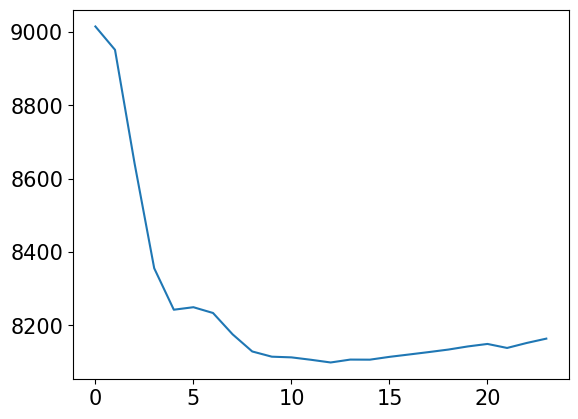

In [22]:
bic, _ = BIC(freq2,clean_sig2)

plt.plot(bic)

/home/garces/.pyenv/versions/3.8-dev/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/garces/.pyenv/versions/3.8-dev/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/garces/.pyenv/versions/3.8-dev/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/garces/.pyenv/versions/3.8-dev/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/garces/.pyenv/versions/3.8-dev/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns,

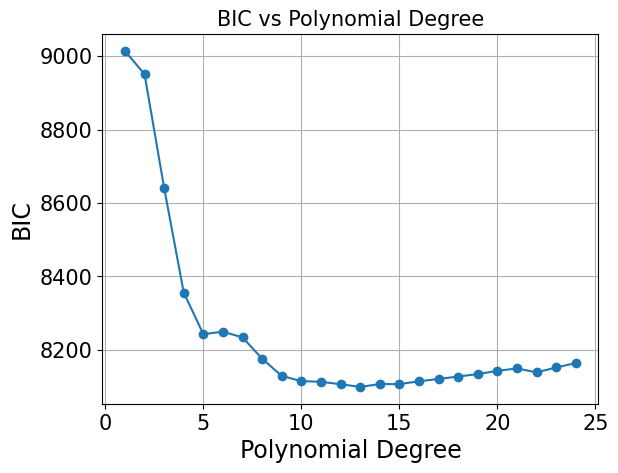

Best polynomial degree: 13


In [23]:

# Range of polynomial degrees to test
degrees = range(1, 25)
bics = []

n = len(freq2)

for deg in degrees:
    # Fit polynomial
    coeffs = np.polyfit(freq2, clean_sig2, deg)
    y_fit = np.polyval(coeffs, freq2)
    
    # Residual sum of squares
    residuals = clean_sig2 - y_fit
    rss = np.sum(residuals ** 2)
    
    # BIC calculation
    k = deg + 1  # Number of parameters in polynomial
    bic = n * np.log(rss / n) + k * np.log(n)
    bics.append(bic)

# Plot BIC vs. degree
plt.plot(degrees, bics, marker='o')
plt.title("BIC vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("BIC")
plt.grid(True)
plt.show()

# Find best degree
best_degree = degrees[np.argmin(bics)]
print(f"Best polynomial degree: {best_degree}")


In [24]:

def window_length(freq, signal):
    """
    Analyze different window lenght to use Savitzky-Golay filters.
    
    Parameters:
        freq (array): Frequency values
        signal (array): Signal values to analyze
        
    Returns:
        tuple: (trends, detrended_signals) containing all filtered results
    """
    
    # Configuration
    windows = [11, 21, 31]
    polyorder = 3
    colors = ['blue', 'orange', 'green']
    titles = ['Detrended (W=11)', 'Detrended (W=21)', 'Detrended (W=31)']
    
    # Calculate trends and detrended signals
    trends = []
    dets = []
    
    for w in windows:
        try:
            trend = savgol_filter(signal, window_length=w, polyorder=polyorder)
            det = signal - trend
            trends.append(trend)
            dets.append(det)
        except ValueError as e:
            print(f"Error with window size {w}: {str(e)}")
            continue
    
    # Create figure and axes
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle('Savitzky-Golay Filter Analysis', fontsize=14)
    
    # Plot original signal with all trends
    axs[0,0].plot(freq, signal, label="Original Signal", color='black', alpha=0.8, linewidth=1.5)
    for i, (w, trend, color) in enumerate(zip(windows, trends, colors)):
        axs[0,0].plot(freq, trend, label=f"window = {w}", alpha=0.8, color=color)
    axs[0,0].legend()
    axs[0,0].grid(True, linestyle='--', alpha=0.6)
    axs[0,0].set_title('Signal with Different SG Filters')
    axs[0,0].set_xlabel('Frequency')
    axs[0,0].set_ylabel('Amplitude')
    
    # Plot detrended signals
    for i, (ax, det, color, title) in enumerate(zip(
        [axs[0,1], axs[1,0], axs[1,1]], 
        dets, 
        colors, 
        titles
    )):
        ax.plot(freq, det, color=color, alpha=0.8)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_title(title)
        ax.set_xlabel('Frequency')
        ax.set_ylabel('Detrended Amplitude')
    
    plt.tight_layout()
    plt.show()
    
    return trends, dets

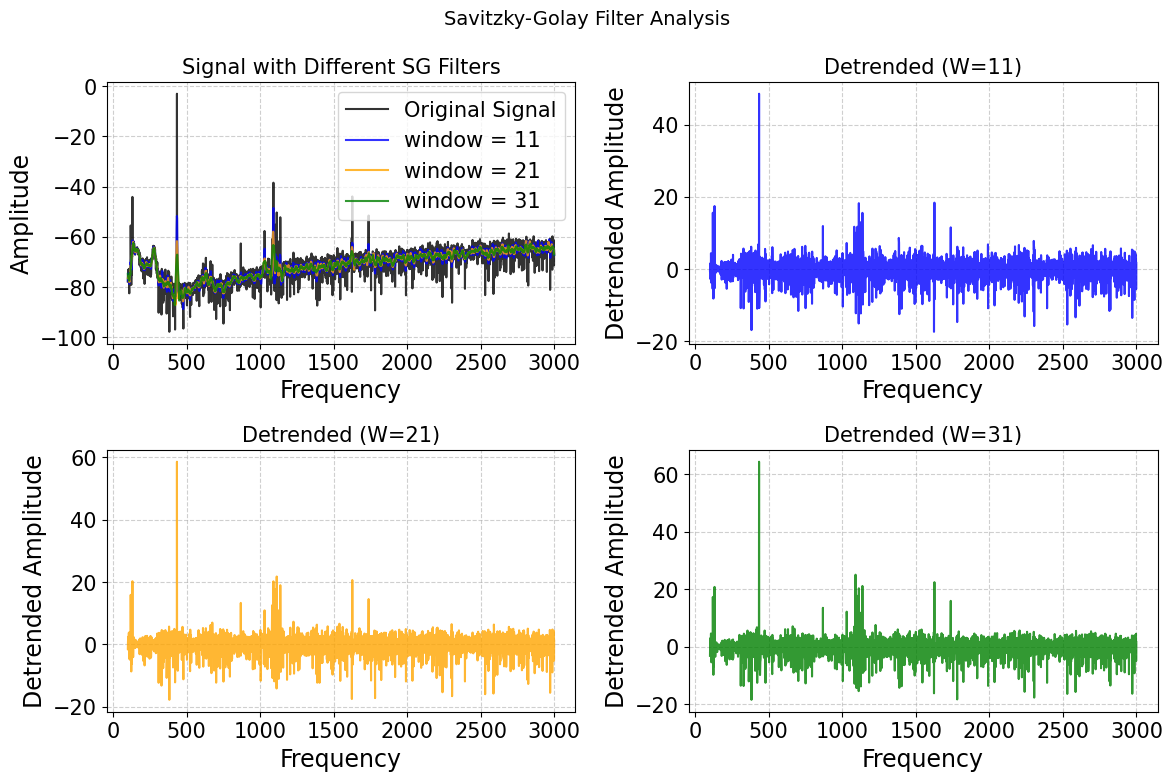

In [25]:
trends, detrended_signals = window_length(freq2, clean_sig2)


In [60]:
detrended_signals[1]

0       -1.422551
1       -1.280593
2        1.868669
3        3.427378
4       -0.183317
           ...   
63975    1.632075
63976    4.126628
63977    4.990649
63978   -0.427569
64000   -5.388398
Name: Clean_dBm, Length: 35072, dtype: float64

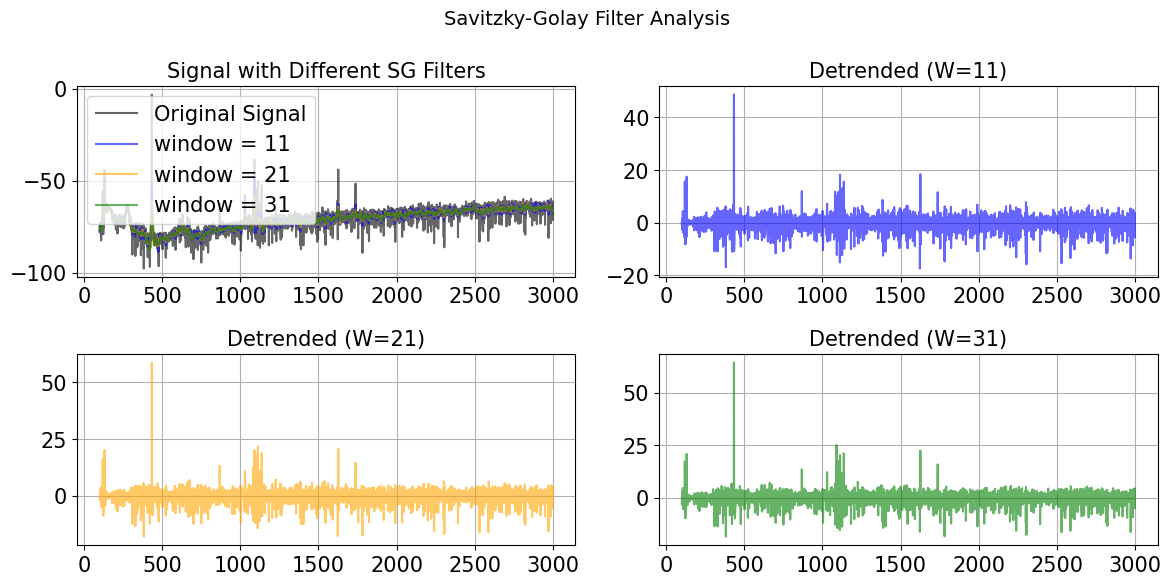

In [26]:
# Try different window lengths

# Parameters
windows = [11, 21, 31]
polyorder = 3

# Create all filtered trends in one loop
trends = [savgol_filter(clean_sig2, window_length=w, polyorder=polyorder) for w in windows]
dets = [clean_sig2 - trend for trend in trends]

# Create figure and axes
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
fig.suptitle('Savitzky-Golay Filter Analysis', fontsize=14)

# Plot original signal and all trends
axs[0,0].plot(freq2, clean_sig2, label="Original Signal", color='black', alpha=0.6)
colors = ['blue', 'orange', 'green']
for i, w in enumerate(windows):
    axs[0,0].plot(freq2, trends[i], label=f"window = {w}", alpha=0.6, color=colors[i])
axs[0,0].legend()
axs[0,0].grid()
axs[0,0].set_title('Signal with Different SG Filters')

# Plot detrended signals in subplots
titles = ['Detrended (W=11)', 'Detrended (W=21)', 'Detrended (W=31)']
for i, (ax, det, color, title) in enumerate(zip(
    [axs[0,1], axs[1,0], axs[1,1]], 
    dets, 
    colors, 
    titles
)):
    ax.plot(freq2, det, label=title, color=color, alpha=0.6)
    #ax.legend()
    ax.grid()
    ax.set_title(title)

plt.tight_layout()


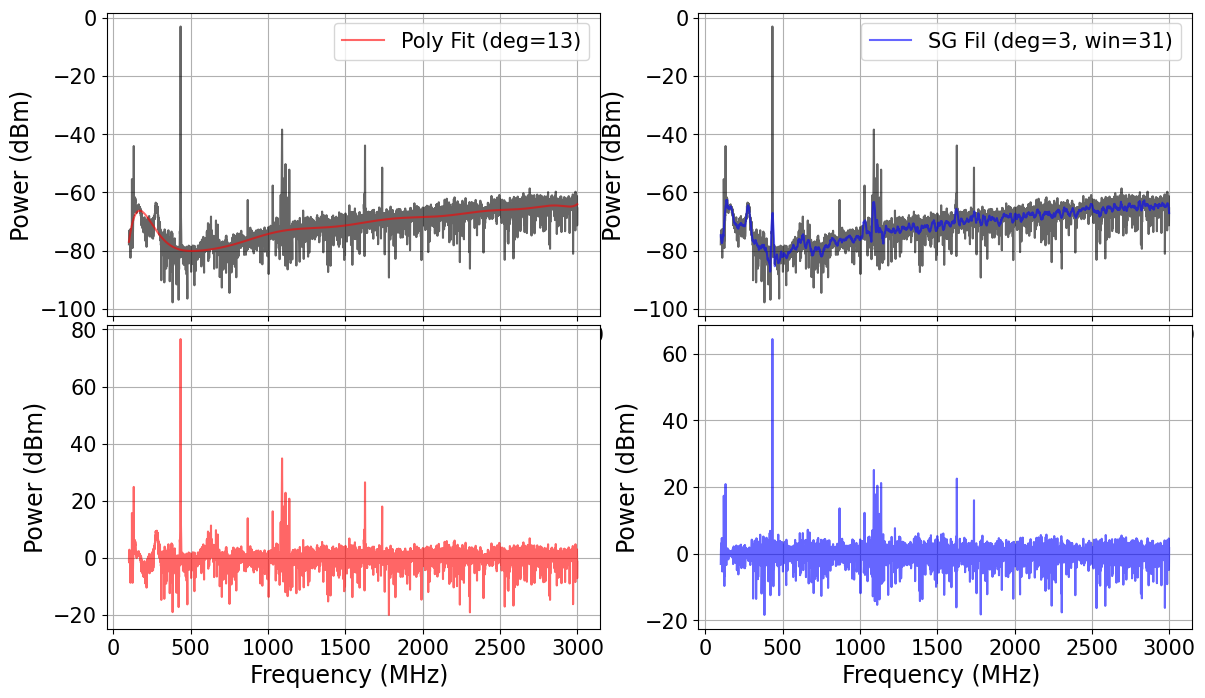

In [28]:
# apply detrending on the signal
degree = 13
coeffs = np.polyfit(freq2, clean_sig2, degree)
poly_trend = np.polyval(coeffs, freq2)
detrended_signal_pol = clean_sig2 - poly_trend


# original_signal: 1D numpy array of your data
window_length = 31  # must be odd
polyorder = 3      # polynomial degree

trend_sg = savgol_filter(clean_sig2, window_length, polyorder)
detrended_signal_sg = clean_sig2 - trend_sg


# plot the detrend signal
fig, axs = plt.subplots(2,2, figsize=(14,8))
fig.subplots_adjust(hspace=0.03)


axs[0,0].plot(freq2, clean_sig2, color='black', alpha=0.6)
axs[0,0].plot(freq2, poly_trend, color='red', label=f'Poly Fit (deg={degree})', alpha=0.6)
axs[0,0].set_ylabel('Power (dBm)')
axs[0,0].legend()
axs[0,0].grid(True)

axs[1,0].plot(freq2, detrended_signal_pol, color='red', alpha=0.6)
axs[1,0].set_xlabel('Frequency (MHz) ')
axs[1,0].set_ylabel('Power (dBm)')
axs[1,0].grid(True)


axs[0,1].plot(freq2, clean_sig2, color='black', alpha=0.6)
axs[0,1].plot(freq2, trend_sg, color='blue', label=f'SG Fil (deg={polyorder}, win={window_length})', alpha=0.6)
axs[0,1].legend()
axs[0,1].set_xlabel('Frequency (MHz) ')
axs[0,1].set_ylabel('Power (dBm)')
axs[0,1].grid(True)


axs[1,1].plot(freq2, detrended_signal_sg, color='blue', alpha=0.6)
#axs[1,1].set_title('BG EIRP')
axs[1,1].set_xlabel('Frequency (MHz) ')
axs[1,1].set_ylabel('Power (dBm)')
axs[1,1].grid(True)


# Identify the peaks.

-- To identify the peaks we will be using the function <find_peanks> from the module <scipy.signal>.

The function has three basic parameter such as:
* height - Minimum height of peaks. Can be a number or tuple (min, max).
* distance - Minimum number of samples between peaks. Useful to avoid detecting nearby noise bumps.
* prominence - Minimum required prominence of peaks. Measures how much a peak stands out from surroundings.


In [29]:
def peaks_detection(signal,h,p,d):
    """
    Parameter:
    signal (array): detrended signal
    h (int): minimum value of the peaks(STD or MAD)
    p (int): how much apeaj stands out form surrounding
    d (int): minimum number os samples between peaks
    
    Retur:
    peaks(array): amplitude of the peaks detetcted
    """

    peak, _ = find_peaks(signal,
                         height=h,
                         prominence=p,
                         distance=d)
    
    return peak

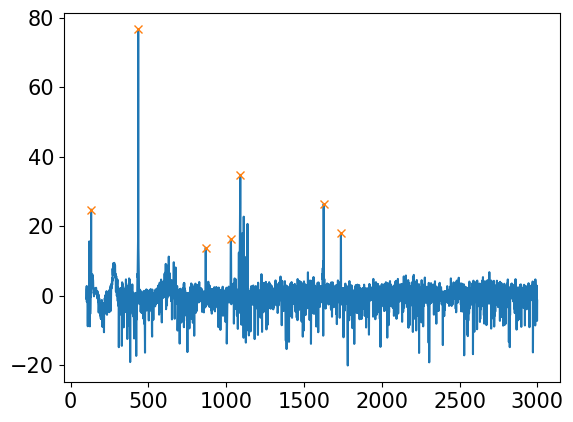

In [30]:
peak = peaks_detection(detrended_signal_pol,3*np.std(detrended_signal_pol),10,50)

plt.plot(freq2,detrended_signal_pol)
plt.plot(freq2.values[peak],detrended_signal_pol.values[peak], 'x')

In [ ]:
peak

(10518,)

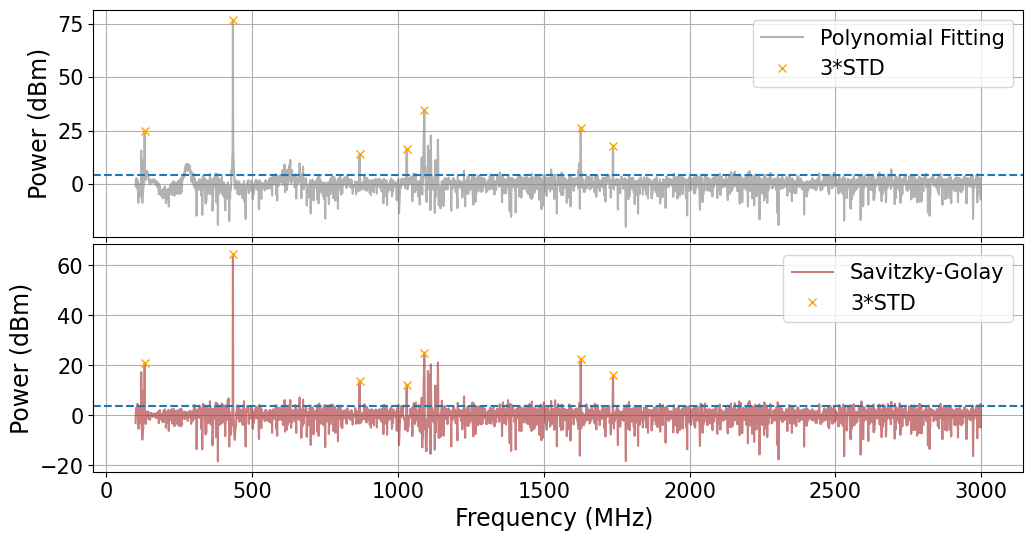

In [31]:
# findd the peaks
peaks_pol, _ = find_peaks(detrended_signal_pol.values, 
                               height=3*np.std(detrended_signal_pol),
                               prominence=10,
                               distance=50
                               )


peaks_sg, _ = find_peaks(detrended_signal_sg.values, 
                               height=3*np.std(detrended_signal_sg),
                               prominence=10,
                               distance=50
                               )



#plot 
fig, axs = plt.subplots(2,1, figsize=(12,6))
fig.subplots_adjust(hspace=0.03)


axs[0].plot(freq2, detrended_signal_pol, color='gray', label= 'Polynomial Fitting', alpha=0.6)
axs[0].plot(freq2.values[peaks_pol], detrended_signal_pol.values[peaks_pol], 'x', label='3*STD',color='orange')
axs[0].axhline(np.std(detrended_signal_pol), linestyle='--')
#axs[0].set_xlim(0,225)
axs[0].set_ylabel('Power (dBm)')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(freq2, detrended_signal_sg, color='brown', label='Savitzky-Golay', alpha=0.6)
axs[1].plot(freq2.values[peaks_sg], detrended_signal_sg.values[peaks_sg], 'x', label = "3*STD", color='orange')
axs[1].axhline(np.std(detrended_signal_sg),linestyle= '--')
axs[1].set_xlabel('Frequency (MHz) ')
axs[1].set_ylabel('Power (dBm)')
#axs[1].set_xlim(0,2000)
axs[1].legend()
axs[1].grid(True)

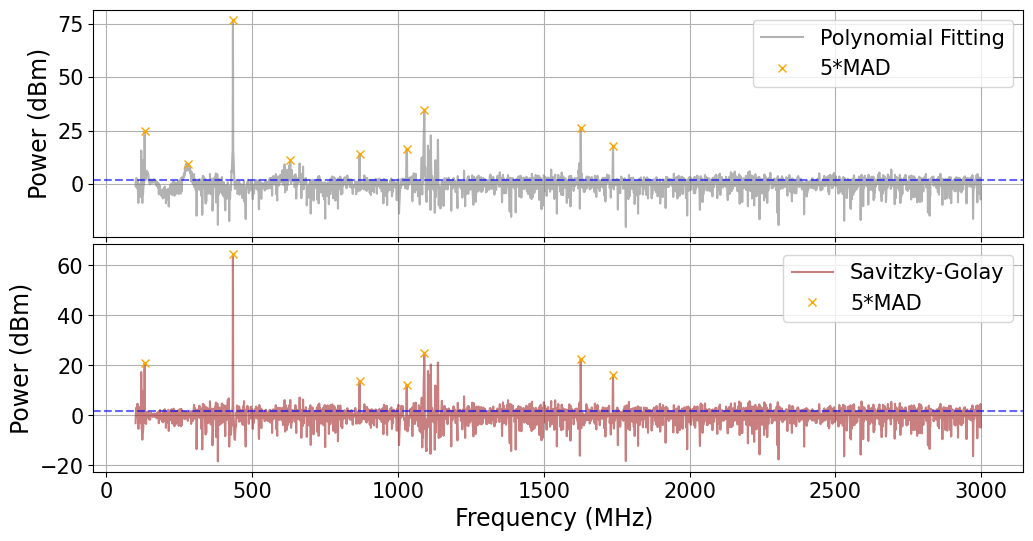

In [32]:
# lets tru with MAD

# findd the peaks
peaks_pol, _ = find_peaks(detrended_signal_pol.values, 
                               height=5*MAD(detrended_signal_pol),
                               prominence=10,
                               distance=50
                               )


peaks_sg, _ = find_peaks(detrended_signal_sg.values, 
                               height=5*MAD(detrended_signal_pol),
                               prominence=10,
                               distance=50
                               )



#plot 
fig, axs = plt.subplots(2,1, figsize=(12,6))
fig.subplots_adjust(hspace=0.03)


axs[0].plot(freq2, detrended_signal_pol, color='gray', label= 'Polynomial Fitting', alpha=0.6)
axs[0].plot(freq2.values[peaks_pol], detrended_signal_pol.values[peaks_pol], 'x',color='orange', label="5*MAD")
axs[0].axhline(y=MAD(detrended_signal_pol), alpha=0.6, color='b', linestyle='--')
#axs[0].set_xlim(0,225)
axs[0].set_ylabel('Power (dBm)')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(freq2, detrended_signal_sg, color='brown', label='Savitzky-Golay', alpha=0.6)
axs[1].plot(freq2.values[peaks_sg], detrended_signal_sg.values[peaks_sg], 'x', color='orange', label="5*MAD")
axs[1].axhline(y=MAD(detrended_signal_sg), alpha=0.6, color='b', linestyle='--')
axs[1].set_xlabel('Frequency (MHz) ')
axs[1].set_ylabel('Power (dBm)')
#axs[1].set_xlim(0,2000)
axs[1].legend()
axs[1].grid(True)

KeyError: '[297, 311, 314, 317, 320, 326, 329, 333, 346, 354, 364, 386, 441, 452, 519, 529, 550, 612, 632, 1956, 1982, 2419, 2445, 2706, 2717, 3049, 3068, 3071, 3211, 3328, 3446, 3657, 3724, 3763, 3769, 3852, 3970, 3980, 4125, 4150, 4164, 4173, 4176, 4179, 4217, 4229, 4234, 4247, 4254, 4262, 4276, 4278, 4281, 4287, 4289, 4294, 4306, 4308, 4310, 4321, 4343, 4367, 4389, 4392, 4413, 4436, 4444, 4466, 4470, 4484, 4487, 4490, 4499, 4502, 4508, 4520, 4523, 4528, 4534, 4544, 4567, 4569, 4604, 4616, 4622, 4626, 4637, 4648, 4662, 4671, 4673, 4676, 4706, 4712, 4722, 4728, 4751, 4756, 4770, 4791, 4794, 4800, 4817, 4826, 4865, 4870, 4875, 4887, 4898, 4907, 4910, 4916, 4924, 4930, 4934, 4952, 4958, 4963, 4994, 4998, 5004, 5010, 5012, 5032, 5043, 5046, 5063, 5071, 5099, 5117, 5126, 5141, 5154, 5156, 5162, 5185, 5193, 5197, 5199, 5213, 5218, 5239, 5248, 5253, 5257, 5272, 5278, 5282, 5284, 5288, 5291, 5298, 5302, 5318, 5320, 5332, 5335, 5338, 5346, 5385, 5388, 5403, 5415, 5418, 5427, 5430, 5435, 5440, 5444, 5461, 5471, 5473, 5476, 5480, 5483, 5495, 5497, 5500, 5507, 5510, 5524, 5529, 5532, 5534, 5538, 5540, 5544, 5549, 5557, 5561, 5576, 5584, 5589, 5591, 5593, 5597, 5602, 5616, 5629, 5639, 5683, 5686, 5688, 5692, 5698, 5704, 5722, 5726, 5728, 5732, 5735, 5737, 5747, 5753, 5756, 5759, 5776, 5778, 5782, 5802, 5808, 5811, 5817, 5823, 5828, 5833, 5873, 5883, 5903, 5906, 5908, 5915, 5919, 5930, 5940, 5943, 5972, 5991, 6011, 6026, 6057, 6060, 6074, 6083, 6094, 6150, 6169, 6173, 6198, 6208, 6216, 6218, 6225, 6228, 6231, 6246, 6249, 6251, 6259, 6281, 6288, 6296, 6312, 6329, 6339, 6346, 6369, 6372, 6377, 6379, 6387, 6408, 6422, 6425, 6440, 6446, 6448, 6453, 6459, 6463, 6471, 6475, 6480, 6494, 6497, 6511, 6526, 6542, 6548, 6552, 6554, 6557, 6561, 6563, 6571, 6584, 6608, 6613, 6615, 6622, 6624, 6631, 6640, 6646, 6654, 6657, 6665, 6669, 6673, 6681, 6688, 6693, 6698, 6701, 6709, 6729, 6733, 6736, 6739, 6743, 6758, 6771, 6788, 6791, 6797, 6800, 6806, 6822, 6831, 6837, 6844, 6897, 6899, 6903, 6907, 6918, 6928, 6941, 6945, 6949, 6953, 6990, 6996, 7004, 7020, 7044, 7056, 7093, 7097, 7112, 7116, 7119, 7127, 7154, 7157, 7164, 7171, 7198, 7206, 7210, 7227, 7231, 7235, 7237, 7246, 7265, 7277, 7283, 7286, 7293, 7296, 7305, 7309, 7311, 7316, 7319, 7345, 7349, 7354, 7360, 7366, 7380, 7390, 7404, 7409, 7437, 7440, 7449, 7451, 7463, 7468, 7471, 7473, 7475, 7478, 7480, 7486, 7499, 7502, 7508, 7516, 7518, 7525, 7529, 7538, 7541, 7549, 7560, 7579, 7581, 7583, 7594, 7607, 7611, 7616, 7627, 7639, 7641, 7644, 7655, 7657, 7670, 7676, 7678, 7680, 7689, 7708, 7712, 7716, 7720, 7733, 7736, 7739, 7744, 7749, 7768, 7780, 7800, 7814, 7822, 7825, 7830, 7833, 7854, 7863, 7870, 7891, 7893, 7903, 7916, 7949, 7977, 8017, 8019, 8060, 8064, 8089, 8100, 8103, 8122, 8136, 8139, 8151, 8156, 8162, 8168, 8181, 8184, 8187, 8208, 8213, 8217, 8220, 8227, 8229, 8235, 8239, 8243, 8257, 8259, 8271, 8277, 8282, 8293, 8302, 8305, 8312, 8318, 8329, 8335, 8343, 8361, 8376, 8379, 8387, 8430, 8432, 8443, 8453, 8459, 8472, 8503, 8515, 8522, 8532, 8553, 8555, 8575, 8580, 8583, 8612, 8614, 8624, 8630, 8641, 8653, 8661, 8669, 8684, 8704, 8710, 8719, 8727, 8730, 8737, 8771, 8781, 8796, 8800, 8803, 8810, 8813, 8818, 8825, 8832, 8835, 8837, 8847, 8850, 8854, 8868, 8882, 8893, 8906, 8925, 8929, 8938, 8945, 8950, 8967, 8972, 8978, 8982, 8988, 8998, 9002, 9009, 9011, 9036, 9039, 9041, 9046, 9068, 9076, 9110, 9116, 9144, 9147, 9149, 9168, 9170, 9184, 9198, 9202, 9215, 9220, 9223, 9235, 9238, 9253, 9255, 9258, 9261, 9282, 9297, 9303, 9320, 9333, 9335, 9338, 9342, 9348, 9353, 9364, 9372, 9374, 9379, 9385, 9387, 9397, 9422, 9429, 9436, 9438, 9445, 9455, 9459, 9462, 9464, 9467, 9475, 9480, 9488, 9508, 9514, 9520, 9522, 9529, 9534, 9563, 9577, 9597, 9604, 9618, 9623, 9625, 9630, 9638, 9647, 9658, 9664, 9668, 9671, 9687, 9716, 9723, 9726, 9729, 9736, 9741, 9747, 9765, 9767, 9803, 9814, 9817, 9819, 9830, 9832, 9847, 9849, 9867, 9882, 9884, 9899, 9904, 9915, 9937, 9942, 9974, 9976, 9978, 9987, 9993, 10025, 10028, 10030, 10035, 10051, 10070, 10073, 10080, 10086, 10088, 10092, 10097, 10107, 10120, 10123, 10127, 10141, 10144, 10158, 10166, 10169, 10171, 10177, 10180, 10195, 10231, 10256, 10258, 10260, 10285, 10290, 10295, 10299, 10301, 10303, 10309, 10311, 10320, 10324, 10358, 10364, 10368, 10370, 10374, 10378, 10380, 10389, 10391, 10411, 10418, 10430, 10456, 10464, 10494, 10497, 10504, 10514, 10522, 10534, 10538, 10546, 10550, 10557, 10568, 10581, 10597, 10599, 10602, 10610, 10628, 10634, 10636, 10640, 10647, 10650, 10658, 10669, 10676, 10680, 10700, 10702, 10704, 10709, 10714, 10725, 10727, 10729, 10733, 10770, 10773, 10777, 10781, 10784, 10792, 10799, 10812, 10818, 10821, 10848, 10857, 10897, 10911, 10935, 10937, 10940, 10967, 10982, 10996, 10998, 11001, 11005, 11015, 11066, 11069, 11080, 11096, 11098, 11114, 11117, 11131, 11133, 11142, 11152, 11166, 11179, 11188, 11192, 11195, 11204, 11212, 11251, 11253, 11255, 11262, 11267, 11270, 11278, 11280, 11284, 11313, 11349, 11367, 11401, 11423, 11429, 11447, 11462, 11469, 11480, 11484, 11503, 11505, 11518, 11521, 11525, 11545, 11553, 11562, 11576, 11579, 11582, 11585, 11590, 11599, 11604, 11609, 11612, 11631, 11651, 11663, 11669, 11678, 11688, 11696, 11710, 11720, 11749, 11764, 11769, 11805, 11818, 11824, 11826, 11842, 11853, 11869, 11883, 11891, 11896, 11912, 11918, 11944, 11963, 11970, 11988, 11993, 11996, 12001, 12013, 12022, 12026, 12059, 12062, 12074, 12079, 12095, 12100, 12104, 12113, 12131, 12151, 12153, 12160, 12167, 12175, 12177, 12185, 12204, 12206, 12216, 12218, 12230, 12232, 12247, 12252, 12257, 12259, 12261, 12265, 12275, 12284, 12299, 12302, 12304, 12314, 12335, 12343, 12350, 12353, 12358, 12362, 12399, 12415, 12425, 12431, 12456, 12472, 12476, 12478, 12489, 12493, 12510, 12518, 12521, 12535, 12547, 12549, 12580, 12595, 12603, 12629, 12658, 12678, 12685, 12695, 12700, 12703, 12719, 12728, 12732, 12743, 12771, 12796, 12802, 12812, 12829, 12853, 12870, 12887, 12889, 12892, 12897, 12902, 12909, 12925, 12947, 12963, 12966, 12992, 13022, 13025, 13030, 13044, 13046, 13055, 13059, 13061, 13071, 13101, 13103, 13105, 13107, 13112, 13117, 13124, 13130, 13134, 13137, 13140, 13153, 13156, 13158, 13169, 13186, 13197, 13199, 13204, 13211, 13213, 13226, 13234, 13237, 13241, 13247, 13254, 13261, 13268, 13281, 13283, 13285, 13287, 13313, 13317, 13333, 13341, 13352, 13354, 13356, 13367, 13381, 13387, 13390, 13392, 13411, 13413, 13424, 13426, 13430, 13432, 13447, 13468, 13473, 13477, 13494, 13497, 13499, 13507, 13515, 13518, 13521, 13523, 13555, 13563, 13565, 13623, 13630, 13633, 13638, 13647, 13653, 13656, 13668, 13676, 13682, 13695, 13703, 13707, 13718, 13720, 13724, 13726, 13733, 13738, 13743, 13746, 13752, 13771, 13778, 13792, 13798, 13804, 13808, 13821, 13867, 13879, 13901, 13905, 13923, 13927, 13930, 13935, 13951, 13953, 13964, 13983, 13990, 13993, 14008, 14014, 14020, 14028, 14038, 14051, 14056, 14058, 14066, 14072, 14082, 14105, 14111, 14124, 14130, 14158, 14170, 14190, 14194, 14202, 14204, 14237, 14245, 14248, 14264, 14267, 14277, 14284, 14288, 14293, 14298, 14315, 14319, 14321, 14329, 14332, 14335, 14345, 14367, 14373, 14381, 14386, 14391, 14409, 14415, 14424, 14428, 14438, 14442, 14459, 14463, 14470, 14473, 14479, 14482, 14486, 14496, 14498, 14501, 14512, 14518, 14531, 14556, 14560, 14565, 14570, 14574, 14581, 14584, 14587, 14590, 14594, 14600, 14606, 14617, 14620, 14646, 14650, 14652, 14660, 14671, 14679, 14686, 14691, 14701, 14712, 14715, 14720, 14727, 14732, 14734, 14737, 14762, 14776, 14787, 14802, 14813, 14819, 14823, 14825, 14851, 14855, 14863, 14869, 14872, 14881, 14886, 14889, 14895, 14904, 14921, 14928, 14935, 14937, 14939, 14944, 14961, 14963, 14969, 14971, 14980, 14995, 14999, 15004, 15008, 15017, 15023, 15038, 15046, 15053, 15062, 15068, 15076, 15106, 15114, 15119, 15124, 15129, 15131, 15135, 15142, 15144, 15153, 15159, 15161, 15167, 15170, 15182, 15186, 15189, 15199, 15207, 15222, 15224, 15238, 15241, 15246, 15250, 15252, 15255, 15266, 15268, 15277, 15283, 15287, 15295, 15303, 15310, 15319, 15323, 15328, 15333, 15340, 15342, 15347, 15356, 15361, 15369, 15375, 15377, 15380, 15382, 15401, 15411, 15416, 15430, 15432, 15437, 15449, 15455, 15458, 15462, 15471, 15477, 15479, 15489, 15505, 15518, 15532, 15536, 15538, 15540, 15545, 15547, 15549, 15551, 15553, 15562, 15572, 15574, 15588, 15595, 15597, 15602, 15610, 15618, 15627, 15630, 15633, 15636, 15643, 15645, 15648, 15650, 15653, 15659, 15665, 15668, 15671, 15674, 15682, 15686, 15688, 15696, 15703, 15705, 15716, 15720, 15723, 15726, 15745, 15752, 15757, 15760, 15768, 15772, 15778, 15783, 15796, 15802, 15836, 15838, 15841, 15858, 15861, 15863, 15865, 15885, 15887, 15902, 15904, 15917, 15937, 15944, 15947, 15952, 15954, 15957, 15971, 15978, 15995, 15999, 16005, 16008, 16014, 16025, 16051, 16054, 16062, 16068, 16071, 16085, 16090, 16120, 16124, 16126, 16134, 16137, 16139, 16142, 16147, 16172, 16180, 16189, 16194, 16201, 16203, 16228, 16231, 16235, 16239, 16244, 16259, 16271, 16276, 16286, 16293, 16295, 16314, 16318, 16326, 16329, 16344, 16357, 16360, 16365, 16367, 16370, 16379, 16381, 16389, 16394, 16397, 16408, 16413, 16417, 16421, 16438, 16441, 16446, 16448, 16452, 16484, 16494, 16500, 16508, 16511, 16518, 16534, 16537, 16546, 16548, 16561, 16583, 16588, 16595, 16599, 16602, 16606, 16611, 16614, 16617, 16628, 16634, 16636, 16647, 16650, 16654, 16664, 16670, 16674, 16682, 16715, 16720, 16723, 16725, 16729, 16742, 16744, 16746, 16766, 16769, 16787, 16796, 16800, 16811, 16816, 16819, 16824, 16830, 16838, 16847, 16852, 16859, 16862, 16864, 16866, 16871, 16880, 16883, 16895, 16902, 16905, 16915, 16917, 16920, 16925, 16932, 16936, 16942, 16944, 16948, 16950, 16968, 16971, 16978, 16995, 16998, 17000, 17005, 17010, 17015, 17024, 17032, 17042, 17044, 17052, 17055, 17059, 17070, 17074, 17078, 17087, 17089, 17091, 17103, 17124, 17144, 17149, 17153, 17156, 17159, 17161, 17166, 17186, 17201, 17203, 17207, 17209, 17211, 17215, 17227, 17229, 17235, 17237, 17247, 17254, 17257, 17261, 17267, 17269, 17273, 17279, 17281, 17283, 17292, 17297, 17302, 17310, 17317, 17319, 17326, 17330, 17333, 17342, 17344, 17357, 17363, 17383, 17389, 17401, 17415, 17439, 17445, 17447, 17450, 17464, 17469, 17473, 17477, 17488, 17500, 17502, 17504, 17507, 17525, 17532, 17535, 17539, 17544, 17547, 17559, 17565, 17573, 17580, 17594, 17600, 17610, 17618, 17625, 17630, 17644, 17663, 17680, 17684, 17686, 17689, 17696, 17737, 17743, 17745, 17749, 17755, 17765, 17767, 17770, 17803, 17821, 17823, 17827, 17830, 17832, 17834, 17838, 17850, 17863, 17868, 17876, 17881, 17888, 17890, 17896, 17898, 17900, 17908, 17918, 17920, 17925, 17932, 17939, 17944, 17949, 17952, 17955, 17959, 17976, 17981, 17983, 17986, 18003, 18006, 18011, 18018, 18022, 18041, 18058, 18062, 18069, 18079, 18081, 18085, 18087, 18102, 18104, 18115, 18120, 18130, 18150, 18157, 18162, 18175, 18181, 18193, 18196, 18198, 18209, 18211, 18236, 18261, 18269, 18284, 18292, 18295, 18301, 18304, 18306, 18315, 18337, 18356, 18360, 18363, 18365, 18370, 18373, 18375, 18377, 18380, 18383, 18385, 18393, 18400, 18408, 18412, 18417, 18425, 18430, 18437, 18460, 18464, 18466, 18471, 18476, 18478, 18488, 18496, 18521, 18536, 18539, 18542, 18547, 18575, 18589, 18601, 18609, 18612, 18616, 18620, 18630, 18634, 18643, 18647, 18650, 18652, 18654, 18666, 18668, 18671, 18674, 18678, 18685, 18688, 18705, 18708, 18717, 18722, 18733, 18737, 18739, 18741, 18743, 18745, 18754, 18757, 18759, 18761, 18764, 18775, 18784, 18801, 18807, 18824, 18838, 18842, 18847, 18851, 18853, 18856, 18861, 18872, 18879, 18882, 18901, 18903, 18905, 18914, 18922, 18926, 18928, 18931, 18937, 18945, 18954, 18961, 18966, 18968, 18973, 18978, 18980, 18984, 18986, 19003, 19005, 19008, 19022, 19026, 19030, 19032, 19050, 19054, 19058, 19081, 19084, 19088, 19090, 19093, 19099, 19101, 19103, 19109, 19112, 19116, 19123, 19129, 19139, 19149, 19152, 19172, 19178, 19187, 19190, 19199, 19202, 19204, 19206, 19208, 19210, 19215, 19218, 19220, 19222, 19224, 19234, 19238, 19253, 19256, 19259, 19262, 19267, 19273, 19280, 19284, 19288, 19297, 19302, 19305, 19307, 19314, 19331, 19334, 19337, 19351, 19357, 19364, 19367, 19374, 19380, 19384, 19390, 19393, 19426, 19428, 19432, 19434, 19437, 19440, 19450, 19456, 19460, 19462, 19475, 19491, 19494, 19499, 19506, 19520, 19522, 19524, 19527, 19538, 19545, 19556, 19564, 19570, 19573, 19581, 19587, 19596, 19600, 19603, 19605, 19607, 19615, 19624, 19631, 19634, 19636, 19638, 19642, 19649, 19651, 19664, 19680, 19689, 19723, 19727, 19739, 19747, 19750, 19761, 19767, 19770, 19774, 19779, 19783, 19786, 19790, 19792, 19794, 19797, 19803, 19806, 19809, 19816, 19818, 19825, 19831, 19839, 19847, 19851, 19856, 19860, 19868, 19874, 19880, 19883, 19887, 19897, 19905, 19908, 19910, 19916, 19927, 19931, 19935, 19937, 19958, 19966, 19972, 19976, 19999, 20004, 20010, 20014, 20017, 20019, 20023, 20026, 20042, 20047, 20049, 20052, 20059, 20062, 20069, 20072, 20074, 20086, 20111, 20120, 20122, 20127, 20131, 20133, 20140, 20162, 20164, 20174, 20187, 20189, 20192, 20197, 20203, 20207, 20214, 20221, 20226, 20231, 20244, 20247, 20255, 20269, 20272, 20280, 20284, 20297, 20299, 20301, 20306, 20308, 20313, 20323, 20329, 20343, 20346, 20349, 20353, 20360, 20367, 20374, 20379, 20383, 20390, 20395, 20411, 20414, 20420, 20439, 20446, 20449, 20451, 20459, 20464, 20470, 20474, 20492, 20497, 20508, 20513, 20515, 20518, 20521, 20523, 20529, 20532, 20539, 20542, 20544, 20548, 20553, 20562, 20570, 20576, 20582, 20584, 20586, 20595, 20599, 20617, 20627, 20629, 20635, 20649, 20654, 20664, 20670, 20673, 20675, 20683, 20687, 20689, 20692, 20696, 20711, 20716, 20722, 20725, 20736, 20746, 20751, 20755, 20768, 20775, 20777, 20783, 20786, 20788, 20791, 20797, 20800, 20809, 20817, 20839, 20847, 20858, 20862, 20866, 20871, 20892, 20897, 20902, 20904, 20908, 20911, 20917, 20923, 20927, 20937, 20940, 20948, 20951, 20958, 20964, 20980, 20983, 20996, 21002, 21004, 21007, 21012, 21018, 21037, 21046, 21051, 21055, 21067, 21084, 21093, 21096, 21099, 21101, 21110, 21113, 21118, 21122, 21126, 21132, 21134, 21136, 21141, 21147, 21150, 21164, 21171, 21179, 21185, 21188, 21199, 21206, 21217, 21226, 21228, 21233, 21240, 21244, 21250, 21253, 21262, 21277, 21279, 21287, 21291, 21295, 21303, 21308, 21310, 21313, 21322, 21344, 21347, 21350, 21360, 21368, 21370, 21374, 21376, 21379, 21384, 21388, 21398, 21401, 21409, 21414, 21418, 21422, 21426, 21429, 21431, 21436, 21439, 21443, 21449, 21453, 21465, 21468, 21472, 21477, 21480, 21493, 21495, 21507, 21523, 21528, 21541, 21549, 21551, 21553, 21561, 21578, 21582, 21597, 21599, 21604, 21611, 21613, 21615, 21618, 21627, 21630, 21633, 21637, 21649, 21664, 21666, 21668, 21673, 21680, 21696, 21699, 21701, 21705, 21707, 21715, 21719, 21722, 21729, 21735, 21740, 21742, 21748, 21756, 21762, 21765, 21773, 21778, 21785, 21791, 21798, 21805, 21827, 21829, 21834, 21842, 21844, 21859, 21865, 21868, 21876, 21882, 21895, 21903, 21909, 21923, 21934, 21948, 21951, 21955, 21965, 21972, 21988, 21990, 21993, 21996, 22000, 22007, 22012, 22014, 22016, 22021, 22023, 22037, 22044, 22048, 22055, 22062, 22083, 22093, 22096, 22101, 22104, 22113, 22135, 22140, 22144, 22171, 22173, 22176, 22191, 22197, 22213, 22217, 22219, 22229, 22234, 22238, 22255, 22261, 22269, 22276, 22283, 22289, 22306, 22313, 22326, 22336, 22346, 22349, 22352, 22357, 22361, 22365, 22367, 22370, 22391, 22401, 22411, 22414, 22419, 22428, 22434, 22438, 22440, 22443, 22459, 22465, 22467, 22478, 22480, 22490, 22493, 22499, 22503, 22505, 22507, 22512, 22537, 22539, 22542, 22544, 22551, 22557, 22560, 22567, 22574, 22578, 22583, 22588, 22603, 22607, 22628, 22631, 22636, 22653, 22657, 22660, 22669, 22672, 22685, 22696, 22699, 22705, 22708, 22719, 22726, 22728, 22735, 22738, 22745, 22748, 22751, 22762, 22765, 22773, 22777, 22784, 22794, 22803, 22806, 22808, 22811, 22815, 22817, 22822, 22833, 22837, 22847, 22859, 22876, 22880, 22888, 22892, 22894, 22904, 22914, 22918, 22924, 22928, 22938, 22946, 22949, 22959, 22966, 22975, 22984, 22986, 22989, 22992, 22997, 23001, 23006, 23011, 23016, 23018, 23022, 23027, 23035, 23045, 23047, 23052, 23055, 23059, 23069, 23075, 23085, 23099, 23105, 23113, 23124, 23126, 23131, 23135, 23143, 23154, 23162, 23165, 23168, 23172, 23177, 23182, 23184, 23188, 23191, 23200, 23204, 23207, 23222, 23224, 23226, 23232, 23234, 23247, 23253, 23257, 23263, 23268, 23271, 23280, 23287, 23291, 23295, 23299, 23308, 23312, 23316, 23321, 23324, 23326, 23328, 23331, 23335, 23342, 23344, 23353, 23357, 23364, 23372, 23375, 23382, 23387, 23390, 23401, 23404, 23408, 23410, 23413, 23423, 23425, 23451, 23456, 23460, 23466, 23470, 23472, 23476, 23481, 23483, 23486, 23491, 23493, 23495, 23497, 23499, 23509, 23515, 23524, 23532, 23556, 23561, 23579, 23596, 23617, 23623, 23630, 23634, 23640, 23644, 23647, 23658, 23668, 23679, 23681, 23687, 23689, 23697, 23700, 23705, 23707, 23711, 23714, 23721, 23724, 23733, 23736, 23741, 23747, 23749, 23752, 23758, 23760, 23767, 23772, 23775, 23784, 23786, 23791, 23797, 23803, 23807, 23812, 23824, 23833, 23848, 23854, 23858, 23903, 23916, 23928, 23930, 23934, 23936, 23953, 23957, 23965, 23972, 23974, 23980, 23990, 23992, 23994, 24002, 24010, 24013, 24019, 24021, 24024, 24028, 24035, 24042, 24044, 24047, 24052, 24058, 24083, 24086, 24088, 24092, 24102, 24109, 24113, 24118, 24125, 24127, 24137, 24144, 24150, 24152, 24156, 24163, 24166, 24170, 24173, 24179, 24183, 24201, 24204, 24230, 24232, 24236, 24238, 24271, 24291, 24295, 24303, 24307, 24314, 24322, 24325, 24328, 24330, 24335, 24338, 24345, 24350, 24379, 24390, 24393, 24396, 24398, 24410, 24412, 24418, 24420, 24422, 24425, 24432, 24437, 24442, 24445, 24448, 24453, 24458, 24466, 24481, 24483, 24485, 24494, 24499, 24502, 24507, 24528, 24532, 24535, 24547, 24549, 24551, 24553, 24555, 24557, 24559, 24566, 24574, 24576, 24589, 24593, 24603, 24607, 24609, 24613, 24619, 24622, 24627, 24631, 24633, 24642, 24646, 24650, 24667, 24674, 24697, 24701, 24718, 24729, 24733, 24748, 24757, 24765, 24767, 24770, 24772, 24777, 24781, 24792, 24794, 24796, 24799, 24817, 24823, 24825, 24831, 24840, 24846, 24853, 24855, 24863, 24865, 24869, 24872, 24879, 24882, 24889, 24896, 24901, 24904, 24906, 24913, 24916, 24923, 24935, 24937, 24941, 24944, 24948, 24952, 24961, 24965, 24967, 24970, 24972, 24978, 24985, 24991, 24993, 24997, 25002, 25006, 25015, 25025, 25054, 25058, 25066, 25072, 25074, 25079, 25095, 25097, 25100, 25104, 25113, 25118, 25121, 25123, 25125, 25132, 25140, 25149, 25166, 25168, 25171, 25184, 25195, 25198, 25200, 25203, 25205, 25211, 25219, 25223, 25228, 25242, 25251, 25255, 25260, 25264, 25266, 25272, 25283, 25286, 25291, 25297, 25299, 25305, 25313, 25319, 25323, 25335, 25340, 25342, 25365, 25371, 25379, 25381, 25384, 25407, 25413, 25420, 25428, 25433, 25439, 25441, 25447, 25450, 25455, 25458, 25476, 25483, 25492, 25501, 25504, 25508, 25513, 25515, 25520, 25522, 25525, 25532, 25536, 25541, 25556, 25558, 25575, 25591, 25599, 25607, 25611, 25617, 25620, 25634, 25638, 25643, 25646, 25648, 25651, 25655, 25657, 25664, 25667, 25669, 25674, 25676, 25680, 25689, 25692, 25694, 25697, 25709, 25731, 25734, 25737, 25752, 25756, 25760, 25764, 25775, 25784, 25789, 25792, 25794, 25798, 25805, 25813, 25815, 25822, 25827, 25829, 25831, 25837, 25840, 25842, 25849, 25870, 25883, 25886, 25889, 25899, 25907, 25913, 25925, 25930, 25933, 25939, 25948, 25962, 25966, 25971, 25977, 25985, 25988, 25992, 25994, 25998, 26009, 26012, 26014, 26024, 26026, 26036, 26039, 26041, 26047, 26050, 26057, 26061, 26067, 26075, 26077, 26079, 26089, 26107, 26109, 26112, 26120, 26123, 26126, 26131, 26136, 26144, 26146, 26150, 26154, 26158, 26172, 26178, 26192, 26195, 26203, 26214, 26216, 26220, 26226, 26232, 26254, 26261, 26263, 26268, 26288, 26295, 26297, 26302, 26306, 26308, 26324, 26326, 26328, 26332, 26336, 26339, 26343, 26353, 26356, 26363, 26389, 26395, 26398, 26401, 26403, 26407, 26410, 26412, 26415, 26424, 26427, 26436, 26438, 26440, 26442, 26448, 26450, 26456, 26467, 26476, 26480, 26511, 26521, 26525, 26530, 26533, 26537, 26548, 26553, 26556, 26564, 26570, 26574, 26580, 26584, 26593, 26597, 26604, 26606, 26615, 26623, 26630, 26633, 26652, 26659, 26669, 26673, 26677, 26688, 26693, 26708, 26712, 26718, 26720, 26725, 26728, 26735, 26740, 26745, 26754, 26762, 26777, 26779, 26783, 26792, 26796, 26799, 26802, 26809, 26815, 26818, 26822, 26824, 26846, 26850, 26860, 26864, 26867, 26871, 26874, 26879, 26884, 26886, 26889, 26891, 26896, 26913, 26915, 26919, 26921, 26925, 26930, 26933, 26937, 26942, 26945, 26953, 26963, 26976, 26991, 26996, 27000, 27019, 27022, 27028, 27036, 27038, 27040, 27044, 27051, 27058, 27064, 27072, 27076, 27080, 27087, 27102, 27105, 27108, 27114, 27119, 27123, 27127, 27136, 27140, 27148, 27151, 27157, 27173, 27176, 27178, 27199, 27202, 27212, 27214, 27217, 27223, 27230, 27260, 27268, 27270, 27273, 27278, 27280, 27288, 27291, 27296, 27300, 27302, 27310, 27322, 27324, 27327, 27330, 27341, 27343, 27345, 27349, 27369, 27373, 27383, 27385, 27387, 27389, 27394, 27396, 27405, 27407, 27412, 27414, 27428, 27431, 27435, 27444, 27457, 27468, 27476, 27482, 27498, 27500, 27503, 27519, 27521, 27524, 27538, 27541, 27545, 27552, 27557, 27562, 27571, 27586, 27596, 27604, 27621, 27632, 27648, 27650, 27658, 27662, 27672, 27674, 27676, 27682, 27688, 27694, 27704, 27726, 27731, 27749, 27753, 27763, 27765, 27768, 27772, 27796, 27819, 27823, 27826, 27831, 27835, 27851, 27860, 27865, 27869, 27885, 27888, 27892, 27896, 27904, 27907, 27914, 27918, 27929, 27932, 27939, 27951, 27954, 27962, 27975, 27977, 27981, 27987, 27990, 27994, 28000, 28033, 28038, 28047, 28062, 28064, 28066, 28072, 28077, 28087, 28089, 28094, 28099, 28107, 28111, 28118, 28143, 28147, 28158, 28162, 28170, 28175, 28178, 28184, 28190, 28194, 28199, 28201, 28208, 28211, 28215, 28222, 28224, 28232, 28237, 28239, 28241, 28243, 28246, 28248, 28250, 28285, 28298, 28305, 28309, 28325, 28327, 28331, 28333, 28335, 28337, 28340, 28345, 28351, 28355, 28358, 28362, 28368, 28375, 28378, 28381, 28387, 28398, 28401, 28406, 28413, 28418, 28423, 28432, 28445, 28449, 28455, 28460, 28464, 28466, 28469, 28474, 28478, 28491, 28507, 28514, 28517, 28523, 28526, 28528, 28532, 28541, 28544, 28546, 28549, 28551, 28554, 28556, 28559, 28562, 28573, 28576, 28580, 28583, 28587, 28608, 28623, 28628, 28633, 28635, 28639, 28647, 28660, 28667, 28669, 28673, 28685, 28692, 28695, 28702, 28711, 28714, 28724, 28737, 28740, 28743, 28765, 28789, 28792, 28804, 28809, 28816, 28820, 28823, 28826, 28830, 28838, 28841, 28844, 28847, 28849, 28854, 28864, 28867, 28869, 28875, 28877, 28895, 28910, 28915, 28919, 28930, 28934, 28939, 28944, 28949, 28954, 28960, 28964, 28973, 28978, 28981, 28986, 28990, 28999, 29006, 29026, 29029, 29031, 29039, 29041, 29043, 29049, 29055, 29065, 29071, 29085, 29091, 29094, 29100, 29108, 29111, 29125, 29128, 29130, 29133, 29142, 29145, 29150, 29158, 29163, 29173, 29175, 29179, 29185, 29188, 29192, 29194, 29202, 29210, 29218, 29223, 29234, 29246, 29248, 29252, 29257, 29269, 29273, 29277, 29280, 29292, 29295, 29298, 29303, 29317, 29319, 29322, 29327, 29331, 29334, 29338, 29340, 29348, 29356, 29373, 29392, 29398, 29407, 29415, 29420, 29423, 29426, 29438, 29446, 29448, 29453, 29462, 29465, 29483, 29486, 29489, 29491, 29505, 29509, 29514, 29516, 29518, 29529, 29536, 29539, 29547, 29559, 29562, 29566, 29580, 29591, 29596, 29598, 29600, 29607, 29609, 29612, 29614, 29632, 29636, 29638, 29647, 29659, 29662, 29666, 29671, 29673, 29682, 29688, 29716, 29721, 29724, 29730, 29734, 29737, 29743, 29745, 29749, 29753, 29757, 29759, 29765, 29768, 29770, 29782, 29796, 29801, 29807, 29812, 29817, 29819, 29824, 29836, 29841, 29846, 29852, 29856, 29864, 29868, 29870, 29884, 29889, 29895, 29900, 29903, 29917, 29923, 29930, 29934, 29937, 29943, 29946, 29953, 29955, 29958, 29961, 29967, 29971, 29974, 29981, 29986, 29988, 29992, 29995, 30002, 30005, 30010, 30014, 30018, 30032, 30042, 30045, 30050, 30065, 30071, 30083, 30085, 30097, 30112, 30119, 30126, 30129, 30137, 30141, 30147, 30149, 30154, 30157, 30159, 30178, 30185, 30188, 30196, 30210, 30216, 30221, 30224, 30241, 30244, 30252, 30255, 30259, 30261, 30263, 30273, 30276, 30281, 30291, 30295, 30297, 30300, 30302, 30309, 30316, 30323, 30330, 30334, 30336, 30340, 30345, 30347, 30349, 30357, 30361, 30369, 30382, 30389, 30391, 30395, 30406, 30409, 30414, 30416, 30420, 30422, 30425, 30445, 30447, 30449, 30452, 30460, 30462, 30479, 30487, 30489, 30493, 30507, 30509, 30513, 30520, 30525, 30527, 30530, 30534, 30542, 30550, 30553, 30561, 30567, 30579, 30582, 30584, 30590, 30592, 30606, 30614, 30617, 30626, 30636, 30638, 30640, 30647, 30649, 30657, 30661, 30667, 30669, 30671, 30696, 30705, 30713, 30715, 30720, 30722, 30725, 30749, 30757, 30766, 30768, 30770, 30778, 30786, 30790, 30805, 30808, 30834, 30839, 30844, 30847, 30849, 30853, 30858, 30860, 30869, 30871, 30877, 30883, 30886, 30892, 30895, 30900, 30903, 30911, 30916, 30933, 30935, 30942, 30947, 30962, 30974, 30984, 30990, 30997, 31001, 31003, 31006, 31008, 31013, 31027, 31030, 31033, 31036, 31042, 31046, 31048, 31051, 31054, 31068, 31077, 31081, 31088, 31103, 31105, 31109, 31119, 31134, 31140, 31157, 31160, 31180, 31195, 31206, 31210, 31214, 31228, 31233, 31236, 31243, 31245, 31251, 31253, 31257, 31261, 31263, 31266, 31272, 31280, 31285, 31297, 31299, 31302, 31307, 31316, 31324, 31334, 31343, 31349, 31354, 31356, 31358, 31368, 31376, 31380, 31400, 31405, 31408, 31413, 31419, 31424, 31433, 31453, 31467, 31472, 31474, 31478, 31483, 31498, 31500, 31502, 31505, 31520, 31527, 31529, 31533, 31537, 31540, 31549, 31555, 31560, 31569, 31574, 31576, 31584, 31594, 31596, 31603, 31611, 31615, 31619, 31625, 31634, 31636, 31638, 31640, 31643, 31647, 31653, 31662, 31671, 31677, 31679, 31684, 31689, 31691, 31696, 31702, 31708, 31712, 31718, 31722, 31724, 31728, 31730, 31733, 31735, 31741, 31751, 31755, 31759, 31763, 31765, 31767, 31769, 31772, 31774, 31781, 31787, 31792, 31804, 31806, 31820, 31827, 31829, 31834, 31836, 31841, 31848, 31854, 31856, 31861, 31864, 31881, 31892, 31922, 31932, 31937, 31941, 31944, 31956, 31965, 31967, 31976, 31986, 32003, 32008, 32026, 32030, 32034, 32048, 32054, 32073, 32085, 32087, 32089, 32099, 32102, 32115, 32121, 32129, 32145, 32148, 32171, 32181, 32196, 32199, 32203, 32232, 32237, 32240, 32247, 32261, 32263, 32277, 32286, 32292, 32313, 32318, 32332, 32338, 32342, 32349, 32351, 32361, 32374, 32378, 32384, 32386, 32390, 32395, 32397, 32404, 32410, 32415, 32417, 32419, 32424, 32429, 32444, 32447, 32450, 32453, 32455, 32479, 32483, 32501, 32505, 32511, 32516, 32522, 32524, 32526, 32530, 32535, 32540, 32546, 32549, 32555, 32558, 32565, 32567, 32573, 32578, 32586, 32590, 32592, 32595, 32608, 32622, 32628, 32632, 32642, 32644, 32656, 32664, 32666, 32669, 32673, 32676, 32703, 32710, 32718, 32720, 32726, 32732, 32735, 32745, 32757, 32761, 32776, 32778, 32789, 32796, 32811, 32814, 32818, 32820, 32825, 32827, 32837, 32842, 32856, 32860, 32862, 32866, 32868, 32870, 32873, 32877, 32879, 32887, 32890, 32893, 32908, 32915, 32934, 32938, 32947, 32950, 32956, 32969, 33000, 33003, 33006, 33009, 33022, 33026, 33045, 33052, 33055, 33062, 33067, 33070, 33083, 33090, 33100, 33107, 33109, 33111, 33119, 33124, 33129, 33136, 33141, 33144, 33149, 33162, 33170, 33179, 33181, 33189, 33192, 33195, 33206, 33208, 33213, 33218, 33221, 33225, 33231, 33241, 33249, 33259, 33264, 33271, 33281, 33291, 33293, 33296, 33299, 33306, 33311, 33316, 33319, 33324, 33326, 33334, 33338, 33343, 33346, 33352, 33363, 33372, 33375, 33379, 33382, 33390, 33399, 33403, 33406, 33409, 33415, 33431, 33435, 33441, 33446, 33460, 33462, 33467, 33472, 33483, 33485, 33488, 33493, 33496, 33499, 33504, 33507, 33514, 33518, 33526, 33529, 33532, 33534, 33539, 33546, 33558, 33560, 33563, 33576, 33587, 33590, 33594, 33604, 33606, 33608, 33613, 33617, 33620, 33623, 33626, 33632, 33646, 33654, 33661, 33667, 33671, 33677, 33680, 33683, 33694, 33697, 33702, 33705, 33723, 33729, 33739, 33747, 33749, 33753, 33764, 33775, 33780, 33790, 33795, 33800, 33809, 33828, 33830, 33838, 33840, 33851, 33855, 33857, 33862, 33867, 33871, 33874, 33877, 33882, 33886, 33890, 33894, 33898, 33903, 33919, 33937, 33939, 33941, 33944, 33946, 33948, 33960, 33969, 33972, 33983, 33985, 33992, 34002, 34014, 34022, 34026, 34032, 34042, 34051, 34053, 34055, 34058, 34064, 34066, 34069, 34074, 34082, 34086, 34089, 34091, 34093, 34107, 34110, 34112, 34116, 34123, 34127, 34132, 34136, 34145, 34156, 34165, 34167, 34180, 34183, 34201, 34204, 34208, 34219, 34223, 34230, 34233, 34244, 34249, 34253, 34257, 34261, 34270, 34273, 34276, 34289, 34293, 34298, 34301, 34309, 34312, 34326, 34330, 34339, 34342, 34348, 34350, 34354, 34356, 34359, 34361, 34368, 34372, 34390, 34398, 34405, 34408, 34419, 34423, 34426, 34433, 34450, 34452, 34457, 34472, 34479, 34486, 34489, 34493, 34495, 34502, 34505, 34509, 34512, 34517, 34520, 34526, 34529, 34533, 34535, 34537, 34539, 34544, 34546, 34553, 34565, 34576, 34578, 34580, 34588, 34592, 34611, 34625, 34631, 34633, 34637, 34640, 34646, 34652, 34658, 34661, 34665, 34667, 34673, 34678, 34683, 34686, 34690, 34695, 34698, 34703, 34715, 34723, 34727, 34741, 34746, 34757, 34765, 34768, 34770, 34772, 34786, 34789, 34792, 34799, 34812, 34836, 34849, 34852, 34862, 34873, 34876, 34888, 34897, 34899, 34922, 34924, 34927, 34930, 34933, 34941, 34964, 34967, 34970, 34974, 34980, 34995, 35006, 35008, 35011, 35014, 35020, 35032, 35039, 35041, 35046, 35058, 35066, 35068] not in index'

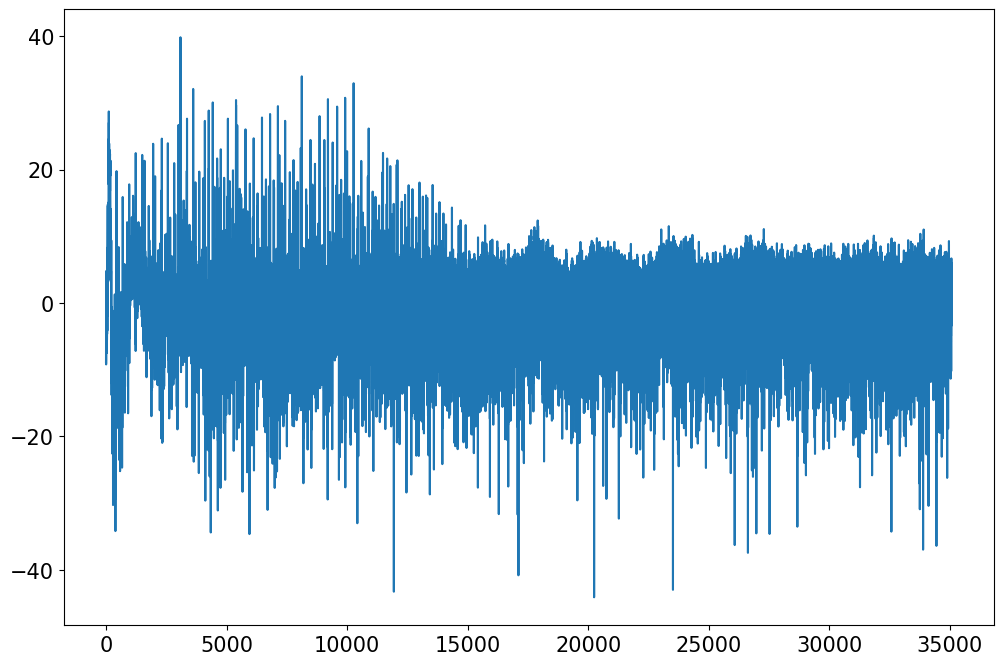

In [29]:
# Test different prominence values
prominence_values = np.linspace(0.1, max(detrended_signal_pol), 10)  # Adjust range as needed

plt.figure(figsize=(12, 8))
plt.plot(detrended_signal_pol.values, label='Original Data')

for prom in prominence_values:
    peaks, _ = find_peaks(detrended_signal_pol, prominence=prom)
    plt.plot(freq2[peaks], detrended_signal_pol.values[peaks], 'x', label=f'Prom={prom:.2f}')

plt.legend()
plt.title('Peak Detection with Different Prominence Values')
plt.show()